In [ ]:
!nvidia-smi

Sat Aug 10 17:15:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install virtualenv

##### Install necessary libraries needed

In [ ]:
!pip3 install natsort
#!pip install opencv-python
#!pip install opencv-python-headless
#!pip install opencv-contrib-python-headless
#!pip3 install -U tensorflow==2.3.0
!pip install livelossplot
# Example to install TensorFlow 2.5.0
!pip install tensorflow==1.15.0
#print(os.getcwd())

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==1.15.0


In [ ]:
# Import the drive module from google.colab
from google.colab import drive
import zipfile
import os
# Mount Google Drive to the specified directory '/content/drive'
drive.mount('/content/drive')

# incase you are not storing the file in google drive, set the FILE directory automatically.
# FILE_DIR = '';

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# only run this if you have a zipped folder and you wish to unzip it.
zip_path = '/content/drive/MyDrive/MESSIDOR.zip'
extract_path = '/content/riga_data'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Data extracted to {extract_path}")

Data extracted to /content/riga_data


importing all relevant libraries

In [ ]:
# Enable inline plotting in Jupyter notebooks
%matplotlib inline
# Standard libraries
import os
from glob import glob
from natsort import natsorted
# Image processing library
import cv2 as cv
# Plotting library
import matplotlib.pyplot as plt
# Machine learning library
from sklearn.model_selection import train_test_split
# Deep learning library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Utility libraries
import warnings
warnings.filterwarnings('ignore')
# TensorFlow Keras layers
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D,
    Conv2DTranspose, Input, Concatenate, Flatten
)
# TensorFlow Keras Model
from tensorflow.keras.models import Model
# TensorFlow Keras metrics
from tensorflow.keras.metrics import Recall, Precision, Accuracy
# Scientific computing libraries
import numpy as np
import pandas as pd
# TensorFlow Keras backend
from tensorflow.keras import backend as K
# TensorFlow Keras callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
# TensorFlow Keras optimizer
from tensorflow.keras.optimizers import Adam
# Image processing libraries
from skimage import color
from skimage.filters import threshold_minimum, threshold_otsu
# Live loss plotting library
from livelossplot import PlotLossesKeras

function definition for re-usability

In [ ]:
# Set TensorFlow logging level to minimize log messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Ignore all warning messages
warnings.filterwarnings('ignore')

def display_image_on_axis(axis, image, title):
    """
    Display an image on a specified axis with a title.

    Parameters:
    axis (matplotlib.axes.Axes): The axis on which to display the image.
    image (numpy.ndarray): The image to display.
    title (str): The title of the image.
    """
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def extract_region_of_interest(image):
    """
    Extract the region of interest (ROI) from an image.

    Parameters:
    image (numpy.ndarray): The input image.
    Returns:
    tuple: A tuple containing the extracted ROI and the original image with markings.
    """
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_image, 120, 255, 1)
    contours = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    ROI = image.copy()
    grayscale = cv.cvtColor(ROI, cv.COLOR_BGR2GRAY)

    # Identify and highlight bright spots in the image
    _, max_value, _, max_location = cv.minMaxLoc(grayscale)
    cv.circle(ROI, max_location, 2, (255, 0, 0), 2)

    blurred = cv.GaussianBlur(grayscale, (101, 101), 8)
    _, max_value, _, max_location = cv.minMaxLoc(blurred)

    cv.circle(ROI, max_location, 101, (255, 255, 0), 10)

    height, width = int(max_location[1]), int(max_location[0])
    half_value = int(max_value) // 2 + 40 if height < 600 else 180

    # Crop the image to focus on the region of interest
    cropped_image = image[max(0, height - half_value):height + half_value,
                          max(0, width - half_value):width + half_value]

    return cropped_image, ROI

def display_image(axis, image_path, title):
    """
    Display an image from a file path on a specified axis with a title.

    Parameters:
    axis (matplotlib.axes.Axes): The axis on which to display the image.
    image_path (str): The file path of the image to display.
    title (str): The title of the image.
    """
    img = cv.imread(image_path, cv.IMREAD_COLOR)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    resized_img = cv.resize(img_rgb, (400, 400))

    axis.imshow(resized_img)
    axis.axis('off')
    axis.set_title(title)

def ensure_directory_exists(directory_path):
    """
    Create a directory if it does not already exist.

    Parameters:
    directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

In [ ]:
def resize_to_rgb(image_bgr):
    """
    Resize an image to 224x224 pixels and convert it to RGB color space.

    Parameters:
    image_bgr (numpy.ndarray): The input image in BGR color space.

    Returns:
    numpy.ndarray: The resized image in RGB color space.
    """
    resized_image = cv.resize(image_bgr, (400, 400))
    return cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)

def extract_optic_disc_and_cup_masks(image):
    """
    Extract masks for the optic disc and cup from an image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    tuple: A tuple containing the optic disc mask and optic cup mask.
    """
    dark_lower_bound = (10, 10, 0)
    dark_upper_bound = (99, 90, 150)

    mask = cv.inRange(image, dark_lower_bound, dark_upper_bound)
    median_filtered = cv.medianBlur(mask, 5)
    contours, _ = cv.findContours(median_filtered, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours_external, _ = cv.findContours(median_filtered, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    optic_disc_mask = mask.copy()
    optic_cup_mask = cv.inRange(image, dark_lower_bound, dark_upper_bound)

    for contour in contours:
        optic_disc_mask = cv.drawContours(optic_disc_mask, [contour], -1, (255, 255, 255), -10)

    for contour in contours_external:
        optic_cup_mask = cv.drawContours(optic_cup_mask, [contour], -1, (0, 0, 0), 10)

    optic_cup_mask_copy = optic_cup_mask.copy()
    median_filtered = cv.medianBlur(optic_cup_mask_copy, 5)
    contours, _ = cv.findContours(median_filtered, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        optic_cup_mask_copy = cv.drawContours(optic_cup_mask_copy, [contour], -1, (255, 255, 255), -10)

    return optic_disc_mask, optic_cup_mask_copy

def create_and_save_optic_cup_images(image_paths, directory_name):
    """
    Create and save optic cup images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    source: https://www.geeksforgeeks.org/delete-a-directory-or-file-using-python/
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        _, optic_cup_mask = extract_optic_disc_and_cup_masks(resized_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), optic_cup_mask)

def create_and_save_optic_disc_images(image_paths, directory_name):
    """
    Create and save optic disc images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        optic_disc_mask, _ = extract_optic_disc_and_cup_masks(resized_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), optic_disc_mask)

def create_and_save_images(image_paths, directory_name):
    """
    Create and save resized RGB images from a list of image paths to a specified directory.

    Parameters:
    image_paths (list): List of image file paths.
    directory_name (str): The directory to save the images in.
    """
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    else:
        for file in glob(directory_name + "/*"):
            os.remove(file)

    for image_path in image_paths:
        image = cv.imread(image_path, cv.IMREAD_COLOR)
        roi_image, _ = extract_region_of_interest(image)
        resized_image = resize_to_rgb(roi_image)
        cv.imwrite(os.path.join(directory_name, os.path.basename(image_path)), resized_image)

In [ ]:
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "riga_data")
print(data_dir)

retina_images_2 = glob(os.path.join(data_dir,"MESSIDOR","image*prime.tif"))
retina_masks_2= glob(os.path.join(data_dir,"MESSIDOR","image*-6.tif"))

# get the images from BinRushed1 dataset
retina_images_1 = glob(os.path.join(data_dir,"BinRushed","BinRushed1-Corrected","image*prime.jpg"))
retina_masks_1 = glob(os.path.join(data_dir,"BinRushed","BinRushed1-Corrected","image*-6.jpg"))

# merge them together.
retina_images_2.extend(retina_images_1)
retina_masks_2.extend(retina_masks_1)

retina_image_paths = natsorted(retina_images_2)
retina_mask_paths = natsorted(retina_masks_2)

/content/riga_data


In [ ]:
# Enable inline plotting in Jupyter notebooks
%matplotlib inline
# Standard Libraries
import os
import warnings
# Data Handling
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted
# Image Processing Libraries
import cv2 as cv
from skimage import color
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
# Data Visualization
import matplotlib.pyplot as plt
# Deep Learning Libraries
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# Keras Preprocessing
from keras.preprocessing.image import load_img, img_to_array
# Model Building
from keras.models import Model
from keras.layers import (
    Layer,
    Conv2D,
    Dropout,
    UpSampling2D,
    concatenate,
    Add,
    Multiply,
    Input,
    MaxPool2D,
    BatchNormalization,
    Flatten,
    Activation,
    Conv2DTranspose,
    Concatenate,
    MaxPooling2D,
    Dense,
    GlobalAveragePooling2D
)
# Callbacks
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, CSVLogger
# Optimizers
from tensorflow.keras.optimizers import Adam
# Metrics
from keras.metrics import MeanIoU
from tensorflow.keras.metrics import Recall, Precision, Accuracy
# Explanation Tools
# from tf_explain.core.grad_cam import GradCAM
# Model Evaluation
from sklearn.model_selection import train_test_split
from natsort import natsorted
import re
from livelossplot import PlotLossesKeras
# Ignore warnings
warnings.filterwarnings("ignore")

Preprocessing.

In [ ]:
# Display the count of retina images and masks
print(f"Total retina images: {len(retina_image_paths)}, total ground truth images: {len(retina_mask_paths)}")

# Split the dataset into training and testing sets (90% train, 10% test)
train_images, test_images, train_masks, test_masks = train_test_split(
    retina_image_paths, retina_mask_paths, test_size=0.1, random_state=56
)
# Further split the training set into training and validation sets (75% train, 25% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.25, random_state=56
)

# Define directories to save the processed images and masks
output_dirs = {
    "retina_train": os.path.join(data_dir, "train/retina"),
    "retina_valid": os.path.join(data_dir, "valid/retina"),
    "retina_test": os.path.join(data_dir, "test/retina"),
    "mask_train_disc": os.path.join(data_dir, "mask_train/disc/retina"),
    "mask_valid_disc": os.path.join(data_dir, "mask_valid/disc/retina"),
    "mask_test_disc": os.path.join(data_dir, "mask_test/disc/retina"),
    "mask_train_cup": os.path.join(data_dir, "mask_train/cup/retina"),
    "mask_valid_cup": os.path.join(data_dir, "mask_valid/cup/retina"),
    "mask_test_cup": os.path.join(data_dir, "mask_test/cup/retina")
}

train_images = natsorted(train_images)
train_masks = natsorted(train_masks)

val_masks = natsorted(val_masks)
val_images = natsorted(val_images)

test_masks = natsorted(test_masks)
test_images = natsorted(test_images)

# Process and save the training, validation, and test images
create_and_save_images(train_images, output_dirs["retina_train"])
create_and_save_images(val_images, output_dirs["retina_valid"])
create_and_save_images(test_images, output_dirs["retina_test"])
# Process and save the optic disc masks
create_and_save_optic_disc_images(train_masks, output_dirs["mask_train_disc"])
create_and_save_optic_disc_images(val_masks, output_dirs["mask_valid_disc"])
create_and_save_optic_disc_images(test_masks, output_dirs["mask_test_disc"])
# Process and save the optic cup masks
create_and_save_optic_cup_images(train_masks, output_dirs["mask_train_cup"])
create_and_save_optic_cup_images(val_masks, output_dirs["mask_valid_cup"])
create_and_save_optic_cup_images(test_masks, output_dirs["mask_test_cup"])

Total retina images: 460, total ground truth images: 460


Total number of retina images and ground truth masks in the dataset:
Train set: Retina images - 310, Ground truth images - 310
Validation set: Retina images - 104, Ground truth images - 104
Test set: Retina images - 46, Ground truth images - 46


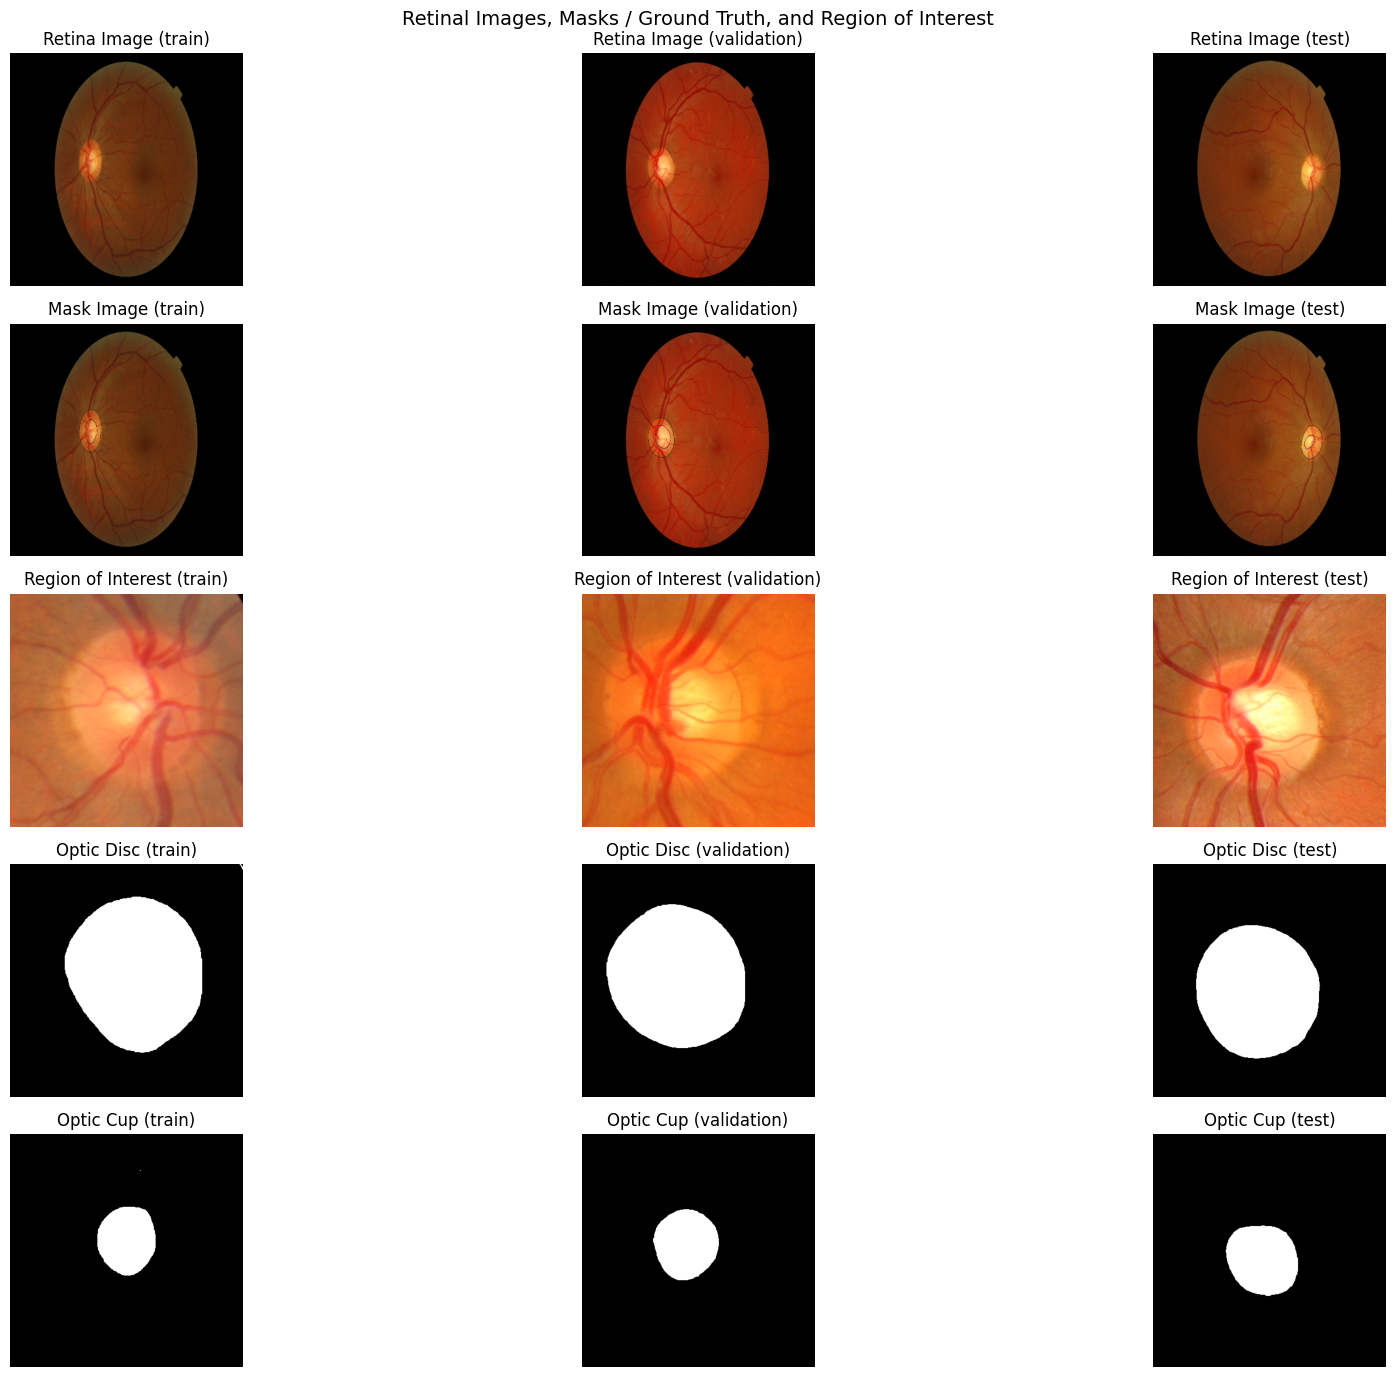

In [ ]:
# Print the total number of train, validation, and test images along with their masks.
print("Total number of retina images and ground truth masks in the dataset:")
print("Train set: Retina images - {}, Ground truth images - {}".format(len(train_images), len(train_masks)))
print("Validation set: Retina images - {}, Ground truth images - {}".format(len(val_images), len(val_masks)))
print("Test set: Retina images - {}, Ground truth images - {}".format(len(test_images), len(test_masks)))


# processed;

# Display a grid of images: retina images, masks, regions of interest, optic discs, and optic cups.
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 14))

# Display retina images
display_image(ax[0, 0], train_images[1], "Retina Image (train)")
display_image(ax[0, 1], val_images[2], "Retina Image (validation)")
display_image(ax[0, 2], test_images[1], "Retina Image (test)")

# Display masks
display_image(ax[1, 0], train_masks[1], "Mask Image (train)")
display_image(ax[1, 1], val_masks[2], "Mask Image (validation)")
display_image(ax[1, 2], test_masks[1], "Mask Image (test)")

# Display regions of interest
display_image_on_axis(ax[2, 0], cv.imread(os.path.join(output_dirs["retina_train"], "image101prime.tif"), cv.IMREAD_COLOR), "Region of Interest (train)")
display_image_on_axis(ax[2, 1], cv.imread(os.path.join(output_dirs["retina_valid"], "image114prime.tif"), cv.IMREAD_COLOR), "Region of Interest (validation)")
display_image_on_axis(ax[2, 2], cv.imread(os.path.join(output_dirs["retina_test"], "image122prime.tif"), cv.IMREAD_COLOR), "Region of Interest (test)")

# Display optic discs
display_image(ax[3, 0], os.path.join(output_dirs["mask_train_disc"], "image101-6.tif"), "Optic Disc (train)")
display_image(ax[3, 1], os.path.join(output_dirs["mask_valid_disc"], "image114-6.tif"), "Optic Disc (validation)")
display_image(ax[3, 2], os.path.join(output_dirs["mask_test_disc"], "image122-6.tif"), "Optic Disc (test)")

# Display optic cups
display_image(ax[4, 0], os.path.join(output_dirs["mask_train_cup"], "image101-6.tif"), "Optic Cup (train)")
display_image(ax[4, 1], os.path.join(output_dirs["mask_valid_cup"], "image114-6.tif"), "Optic Cup (validation)")
display_image(ax[4, 2], os.path.join(output_dirs["mask_test_cup"], "image122-6.tif"), "Optic Cup (test)")

# Add overall title and adjust layout
plt.suptitle("Retinal Images, Masks / Ground Truth, and Region of Interest", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Data preprocessing - normalize data for both training and validation sets
# Inspired by: Ideas from various sources on image data augmentation

seed = 56  # Seed for consistent image and mask transformations
IMG_SIZE = (400, 400)
batch_size = 6

# Image data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    height_shift_range=0.5
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Configure generators for training images and masks (disc)
train_image_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, subset="training", color_mode="rgb"
)

train_mask_generator_disc = train_datagen.flow_from_directory(
    os.path.join(data_dir, "mask_train", "disc"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

train_mask_generator_cup = train_datagen.flow_from_directory(
    os.path.join(data_dir, "mask_train", "cup"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

# Configure generators for validation images and masks (disc)
val_image_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "valid"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="rgb"
)

val_mask_generator_disc = val_datagen.flow_from_directory(
    os.path.join(data_dir, "mask_valid", "disc"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

val_mask_generator_cup = val_datagen.flow_from_directory(
    os.path.join(data_dir, "mask_valid", "cup"),
    target_size=IMG_SIZE, batch_size=batch_size, class_mode=None,
    seed=seed, shuffle=False, color_mode="grayscale"
)

# Combine generators for training and validation (disc)
train_generator_disc = zip(train_image_generator, train_mask_generator_disc)
val_generator_disc = zip(val_image_generator, val_mask_generator_disc)
train_generator_cup = zip(train_image_generator, train_mask_generator_cup)
val_generator_cup = zip(val_image_generator, val_mask_generator_cup)

Found 310 images belonging to 1 classes.
Found 310 images belonging to 1 classes.
Found 310 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
Found 104 images belonging to 1 classes.


In [ ]:
train_batch_cup = next(train_generator_cup)
val_batch_cup = next(val_generator_cup)

# Check the shape of the images and masks in the batch
print("Training data shape:", train_batch_cup[0][0].shape)  # Shape of the training images
print("Training mask shape:", train_batch_cup[0][1].shape)  # Shape of the training masks
print("Validation data shape:", val_batch_cup[0][0].shape)  # Shape of the validation images
print("Validation mask shape:", val_batch_cup[0][1].shape)  # Shape of the validation masks

Training data shape: (400, 400, 3)
Training mask shape: (400, 400, 3)
Validation data shape: (400, 400, 3)
Validation mask shape: (400, 400, 3)


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
def custom_generator(image_gen, mask_gen):
    while True:
        # Get image and mask batches
        image_batch = next(image_gen).astype(np.float32)  # Cast to float32
        mask_batch = next(mask_gen).astype(np.float32)  # Cast to float32

        # Ensure masks are binary (if necessary)
        mask_batch = (mask_batch > 0.5).astype(np.float32)

        yield (image_batch, mask_batch)


train_generator_cup = custom_generator(train_image_generator, train_mask_generator_cup)
val_generator_cup = custom_generator(val_image_generator, val_mask_generator_cup)

model building; using the UNET architecture. This model was adopted from pre-existing model architecture.
modified from: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [ ]:
def conv_block(input_tensor, num_filters):
    """
    Construct a convolutional block consisting of two convolutional layers followed by BatchNormalization and ReLU activation.
    modified from: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

    Args:
    - input_tensor (tensor): Input tensor to the block.
    - num_filters (int): Number of filters (kernels) for convolutional layers.

    Returns:
    - tensor: Output tensor from the convolutional block.
    """
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def enc_block(input_tensor, num_filters, dropout_rate):
    """
    Construct an encoder block (contraction path) consisting of a convolutional block followed by MaxPooling and Dropout.

    Args:
    - input_tensor (tensor): Input tensor to the block.
    - num_filters (int): Number of filters (kernels) for convolutional layers.
    - dropout_rate (float): Dropout rate for the Dropout layer.

    Returns:
    - tuple: Tuple of tensors (skip_tensor, pooled_tensor) where:
             - skip_tensor: Tensor after the convolutional block (used for skip connections).
             - pooled_tensor: Tensor after MaxPooling and Dropout.
    """
    x = conv_block(input_tensor, num_filters)
    pooled_tensor = MaxPool2D((2, 2))(x)
    pooled_tensor = Dropout(dropout_rate)(pooled_tensor)
    return x, pooled_tensor

def dec_block(input_tensor, skip_tensor, num_filters, dropout_rate):
    """
    Construct a decoder block (expansion path) consisting of Conv2DTranspose, Concatenate (skip connection), Dropout, and a convolutional block.

    Args:
    - input_tensor (tensor): Input tensor to the block (from the previous layer).
    - skip_tensor (tensor): Tensor from the skip connection (from the encoder).
    - num_filters (int): Number of filters (kernels) for convolutional layers.
    - dropout_rate (float): Dropout rate for the Dropout layer.

    Returns:
    - tensor: Output tensor from the decoder block.
    """
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(input_tensor)
    x = Concatenate()([x, skip_tensor])
    x = Dropout(dropout_rate)(x)
    x = conv_block(x, num_filters)
    return x

def build_unet_model(input_shape):
    """
    Build and return a U-Net model for semantic segmentation.

    Args:
    - input_shape (tuple): Shape of input tensor (e.g., (height, width, channels)).

    Returns:
    - keras.Model: Compiled U-Net model.
    """
    input_tensor = Input(input_shape)

    # Encoder (contracting path)
    skip1, pool1 = enc_block(input_tensor, 64, 0.1)
    skip2, pool2 = enc_block(pool1, 128, 0.1)
    skip3, pool3 = enc_block(pool2, 256, 0.1)
    skip4, pool4 = enc_block(pool3, 512, 0.1)

    # Bridge
    bridge = conv_block(pool4, 1024)

    # Decoder (expanding path)
    decode1 = dec_block(bridge, skip4, 512, 0.1)
    decode2 = dec_block(decode1, skip3, 256, 0.1)
    decode3 = dec_block(decode2, skip2, 128, 0.1)
    decode4 = dec_block(decode3, skip1, 64, 0.1)

    # Output block
    output = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(decode4)

    # Create model
    model_unet = Model(input_tensor, output, name="ret_u-net")
    return model_unet

defining the model metrics (performance metrics and lost functions)

In [ ]:
import tensorflow as tf
from keras.layers import Flatten

def intersection_over_union(y_true, y_pred, smooth=1e-15):
    """
    Compute Intersection over Union (IoU) for semantic segmentation.

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: IoU score (Jaccard index).
    """
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


def dice_coefficient(y_true, y_pred, smooth=1e-15):
    """
    Compute Dice coefficient for semantic segmentation.
    modified from: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: Dice coefficient score.
    """
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-15):
    """
    Compute Dice loss for semantic segmentation.
    modified from: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

    Args:
    - y_true (tensor): Ground truth mask (binary).
    - y_pred (tensor): Predicted mask (binary).
    - smooth (float): Smoothing factor to prevent division by zero.

    Returns:
    - tf.Tensor: Dice loss.
    """
    return 1.0 - dice_coefficient(y_true, y_pred, smooth)

model training for optic disc

In [ ]:
epochs = 60
batch = 6
lr = 7e-5

metrics = [dice_coefficient, intersection_over_union]
loss = [dice_loss]

def setup_environment(data_dir):
    """
    Set up environment variables and create necessary directories.
    data_dir: represents the directory path.

    """

    log_file = os.path.join(data_dir, "files")
    ensure_directory_exists(log_file)
    return log_file

def launch_model(log_file, train_ret_, validation_ret, csv_file, h5_file, lr, batch, epochs):
    """
    Train the U-Net model for optic disc segmentation.

    Args:
    - log_file (str): Path to the directory for logging model and CSV files.
    - train_ret_ (list): List of paths to training retina images.
    - validation_ret (list): List of paths to validation retina images.
    """
    # Set model hyperparameters
    BATCH = batch
    learning_rate = lr
    num_epochs = epochs
    model_path = os.path.join(log_file, h5_file)
    csv_path = os.path.join(log_file, csv_file)

    train_steps = len(train_ret_) // BATCH
    val_steps = len(validation_ret) // BATCH
    input_shape = (400, 400, 3)

    # Build and summarize the U-Net model for optic segmentation
    retina_model = build_unet_model(input_shape)
    print(retina_model.summary())

    return retina_model, train_steps, val_steps, model_path, csv_path

def train_model(model, train_generator, val_generator, num_epochs, train_steps, val_steps, model_path, csv_path, metrics, lr, loss):
    """
    Train the U-Net model.

    Args:
    - model (tf.keras.Model): The U-Net model to train.
    - train_generator (generator): Generator for training data.
    - val_generator (generator): Generator for validation data.
    - num_epochs (int): Number of training epochs.
    - train_steps (int): Steps per epoch for training.
    - val_steps (int): Validation steps.
    - model_path (str): Path to save the best model.
    - csv_path (str): Path to save the training log.
    - metrics (list): List of metrics to evaluate the model.
    - lr (float): Learning rate for the optimizer.

    Returns:
    - history: Training history.
    """

    # Compile the model with the given loss, optimizer, and metrics
    model.compile(
        loss=loss,
        optimizer=Adam(lr),
        metrics=metrics
    )


    # Define the callbacks
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
        PlotLossesKeras()
    ]

    # Train the model and return the history
    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=callbacks
    )

    return history


log_file = setup_environment(data_dir)
cup_model, train_steps, val_steps, cup_model_path, cup_csv_path = launch_model(
    log_file, train_images, val_images, "optic_cup.csv", "optic_cup.keras", lr, batch, epochs)

Model: "ret_u-net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 400, 400, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 400, 400, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 400, 400, 64)   │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 400, 400, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 400, 400, 64)   │         36,928 │ activation_36[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 400, 400, 64)   │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 400, 400, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 200, 200, 64)   │              0 │ activation_37[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 200, 200, 64)   │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 200, 200, 128)  │         73,856 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 200, 200, 128)  │            512 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 200, 200, 128)  │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 200, 200, 128)  │        147,584 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 200, 200, 128)  │            512 │ conv2d_41[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 200, 200, 128)  │              0 │ batch_normalization_3… │
│ (Activation)         

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

None


fit and compile

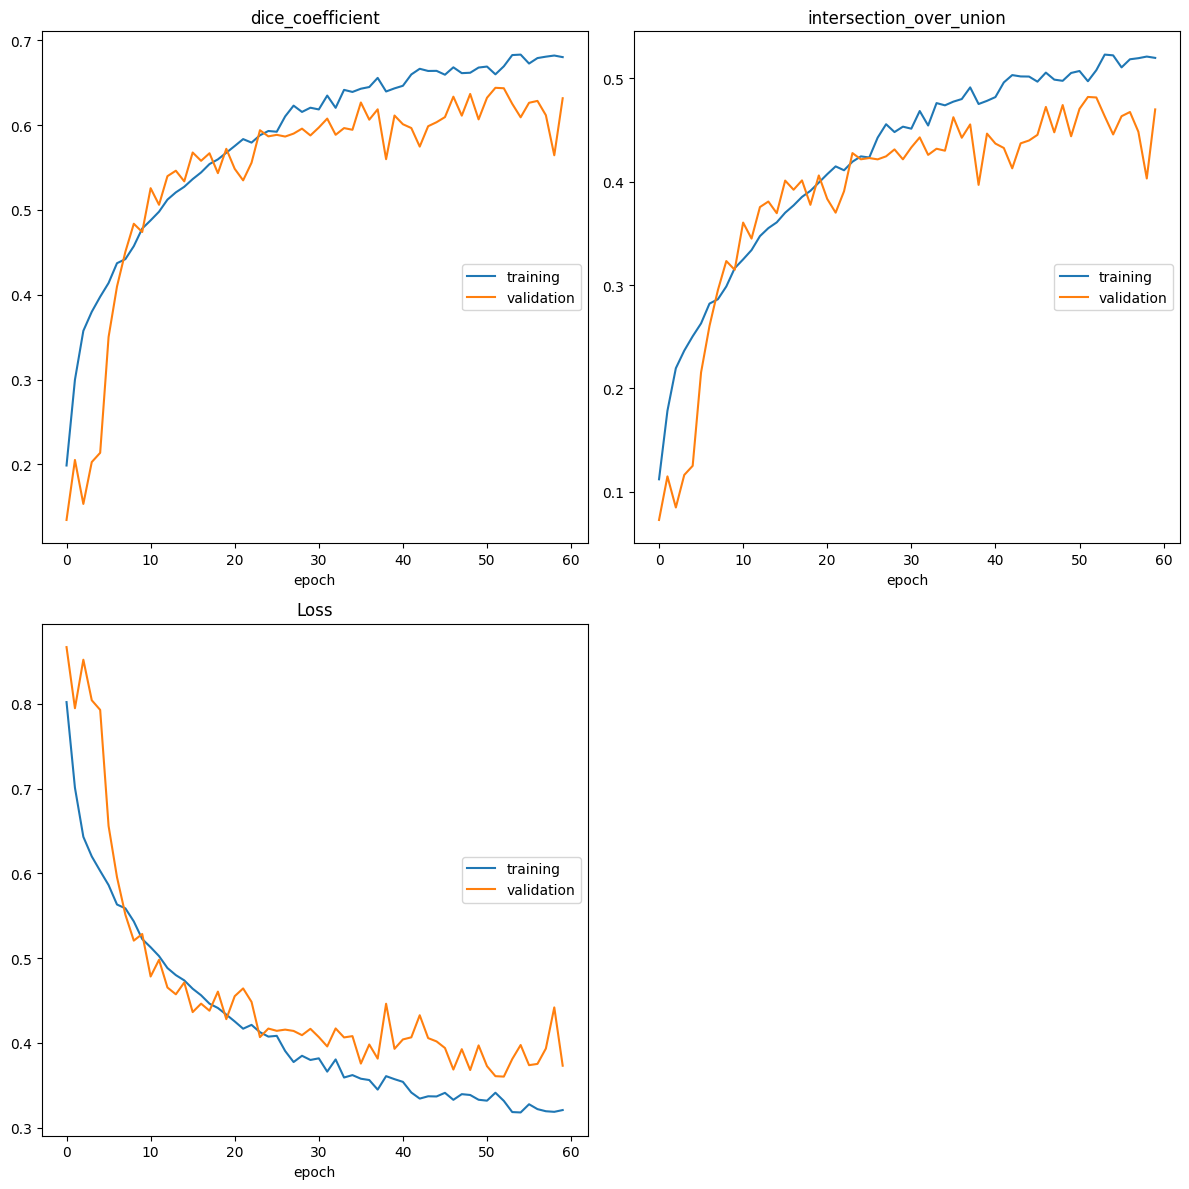

dice_coefficient
	training         	 (min:    0.199, max:    0.683, cur:    0.680)
	validation       	 (min:    0.134, max:    0.644, cur:    0.632)
intersection_over_union
	training         	 (min:    0.112, max:    0.523, cur:    0.520)
	validation       	 (min:    0.073, max:    0.482, cur:    0.470)
Loss
	training         	 (min:    0.318, max:    0.802, cur:    0.321)
	validation       	 (min:    0.360, max:    0.867, cur:    0.373)
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - dice_coefficient: 0.6853 - intersection_over_union: 0.5278 - loss: 0.3170 - val_dice_coefficient: 0.6316 - val_intersection_over_union: 0.4700 - val_loss: 0.3731


In [ ]:
optic_cup_history = train_model(cup_model, train_generator_cup, val_generator_cup,
                                 epochs, train_steps, val_steps, cup_model_path, cup_csv_path, metrics, lr, loss)

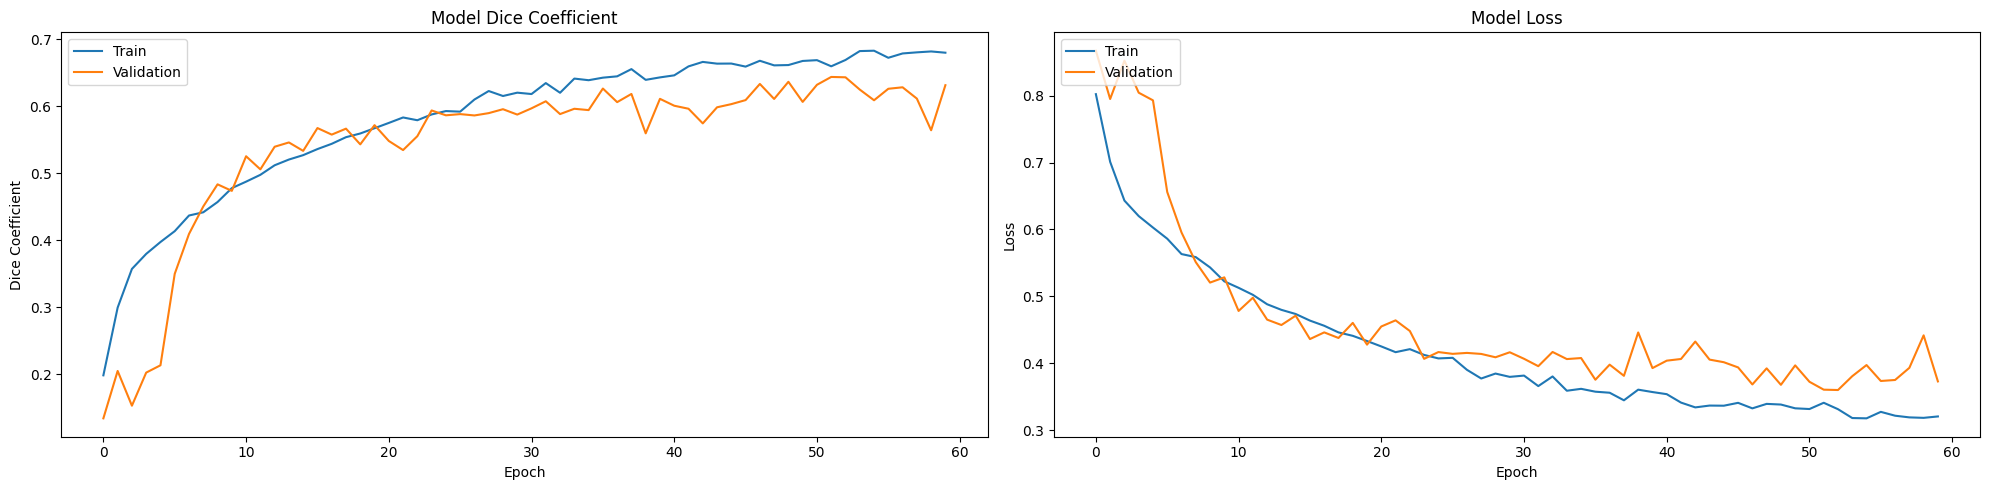

In [ ]:
def plot_metric(history, metric, title, ylabel, subplot_position):
    """
    Plot training and validation metric from history.

    Args:
    - history (History): The training history returned by model.fit().
    - metric (str): The metric to plot (e.g., 'dice_coef').
    - title (str): The title of the plot.
    - ylabel (str): The label for the y-axis.
    - subplot_position (tuple): The position of the subplot (nrows, ncols, index).
    """
    plt.subplot(*subplot_position)
    plt.plot(history.history[metric], label='Train')
    plt.plot(history.history[f'val_{metric}'], label='Validation')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

def summarize_training_history(history):
    """
    Summarize the training history by plotting the training and validation metrics.

    Args:
    - history (History): The training history returned by model.fit().
    """
    plt.figure(figsize=(20, 5))
    # Plot Dice Coefficient
    plot_metric(history, 'dice_coefficient', 'Model Dice Coefficient', 'Dice Coefficient', (1, 2, 1))
    # Plot Loss
    plot_metric(history, 'loss', 'Model Loss', 'Loss', (1, 2, 2))

    plt.tight_layout()
    plt.show()

summarize_training_history(optic_cup_history)

In [ ]:
train = natsorted(glob(os.path.join(output_dirs['retina_train'],"*.*")))
valid = natsorted(glob(os.path.join(output_dirs['retina_valid'],"*.*")))
test = natsorted(glob(os.path.join(output_dirs['retina_test'],"*.*")))

train_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_train_cup'],"*.*")))
train_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_train_disc'],"*.*")))

valid_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_valid_cup'],"*.*")))
valid_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_valid_disc'],"*.*")))

test_mask_cup = natsorted(glob(os.path.join(output_dirs['mask_test_cup'],"*.*")))
test_mask_disc = natsorted(glob(os.path.join(output_dirs['mask_test_disc'],"*.*")))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

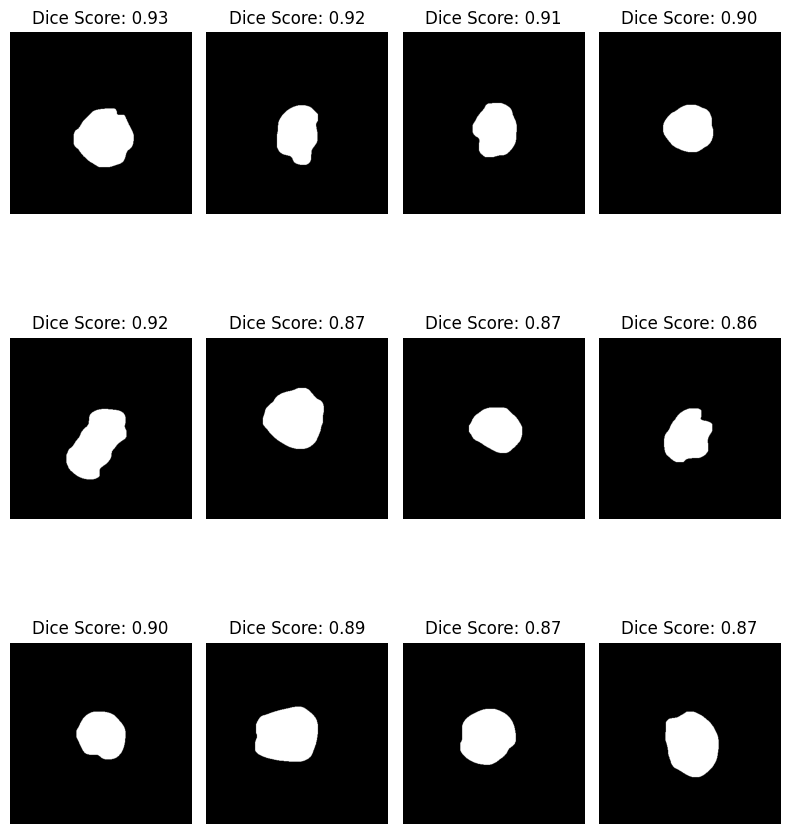

In [ ]:
import os
import cv2 as cv
import numpy as np
from skimage.segmentation import clear_border, mark_boundaries
import matplotlib.pyplot as plt

def display_image_with_prediction(axis, image, title):
    axis.imshow(image, cmap='gray')
    axis.axis('off')
    axis.set_title(title)

def process_and_save_predictions(images, masks, save_directory, model):
    scores = []
    processed_images = []
    score_dict = {}

    os.chdir(save_directory)
    for idx, image_path in enumerate(images):
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        resized_image = cv.resize(image, (400, 400))
        yuv_image = cv.cvtColor(resized_image, cv.COLOR_RGB2YUV)

        clahe = cv.createCLAHE(clipLimit=1, tileGridSize=(2, 2))
        yuv_image[:, :, 0] = clahe.apply(yuv_image[:, :, 0])
        processed_image = cv.cvtColor(yuv_image, cv.COLOR_YUV2RGB)
        filtered_image = cv.bilateralFilter(processed_image, 9, 75, 75)

        normalized_image = filtered_image / 255.0
        normalized_image = normalized_image.astype(np.float32)
        normalized_image = np.expand_dims(normalized_image, axis=0)

        prediction = model.predict(normalized_image)[0]
        prediction = np.where(prediction > 0.5, 1.0, 0.0)

        refined_prediction = np.squeeze(prediction, axis=-1)
        resized_prediction = cv.resize(refined_prediction, (400, 400))

        kernel = np.ones((15, 15), np.uint8)
        final_prediction = cv.morphologyEx(resized_prediction, cv.MORPH_OPEN, kernel)
        final_prediction = final_prediction.astype(np.float32)

        cv.imwrite(f"prediction-{idx}.jpg", final_prediction)

        ground_truth = cv.imread(masks[idx])
        ground_truth = cv.cvtColor(ground_truth, cv.COLOR_BGR2GRAY)
        ground_truth = ground_truth.astype(np.float32) / 255.0

        dice_score = dice_coefficient(ground_truth, final_prediction, smooth=1)
        scores.append(float(dice_score))
        processed_images.append(final_prediction)
        score_dict[idx] = float(dice_score)

    return np.mean(scores) * 100, score_dict, processed_images, scores

# Directories for saving results
result_train_folder_cup = os.path.join(data_dir, "result/train/cup")
result_valid_folder_cup = os.path.join(data_dir, "result/valid/cup")
result_test_folder_cup = os.path.join(data_dir,"result/test/cup")

ensure_directory_exists(result_train_folder_cup)
ensure_directory_exists(result_valid_folder_cup)
ensure_directory_exists(result_test_folder_cup)

# Generating predictions and saving results
train_score, train_dict, train_images, train_scores = process_and_save_predictions(train, train_mask_cup, result_train_folder_cup, cup_model)
valid_score, valid_dict, valid_images, valid_scores = process_and_save_predictions(valid, valid_mask_cup, result_valid_folder_cup, cup_model)
test_score, test_dict, test_images, test_scores = process_and_save_predictions(test, test_mask_cup, result_test_folder_cup, cup_model)

# Sorting results for display
train_top_scores = sorted(train_dict, reverse=True)[:4]
valid_top_scores = sorted(valid_dict, reverse=True)[:4]
test_top_scores = sorted(test_dict, reverse=True)[:4]

train_top_values = sorted(train_scores, reverse=True)[:4]
valid_top_values = sorted(valid_scores, reverse=True)[:4]
test_top_values = sorted(test_scores, reverse=True)[:4]

print(f"Train Dice Coefficient Score: {train_score:.2f}")
print(f"Validation Dice Coefficient Score: {valid_score:.2f}")
print(f"Test Dice Coefficient Score: {test_score:.2f}")

# Displaying the top results
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 10))
for i in range(4):
    display_image_with_prediction(axes[0, i], train_images[train_top_scores[i]], f"Dice Score: {train_top_values[i]:.2f}")
    display_image_with_prediction(axes[1, i], valid_images[valid_top_scores[i]], f"Dice Score: {valid_top_values[i]:.2f}")
    display_image_with_prediction(axes[2, i], test_images[test_top_scores[i]], f"Dice Score: {test_top_values[i]:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
# Function to identify the last convolutional layer in a model
def find_last_conv_layer(model):
    """
    Identify the last convolutional layer in the given model.

    Parameters:
        model (Model): The Keras model instance.

    Returns:
        str: The name of the last convolutional layer.
    """
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    return None

# Retrieve the name of the last convolutional layer
last_conv_layer = find_last_conv_layer(cup_model)
print("Last Convolutional Layer:", last_conv_layer)


Last Convolutional Layer: conv2d_56


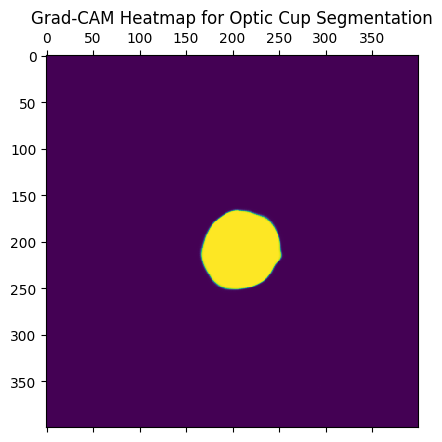

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path, target_size=(400, 400)):
    """
    Load and preprocess an image.

    Parameters:
        img_path (str): Path to the image file.
        target_size (tuple): Desired image size.

    Returns:
        numpy.array: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

image_path = 16
img_path = train[image_path]  # Replace with your image path
input_image = preprocess_image(img_path)

def generate_gradcam_heatmap(model, img_array, conv_layer_name):
    """
    Generate a Grad-CAM heatmap for a given model and image.

    Parameters:
        model (Model): The Keras model.
        img_array (numpy.array): Preprocessed input image.
        conv_layer_name (str): Name of the convolutional layer.

    Returns:
        numpy.array: Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Use the last convolutional layer before the output
last_conv_layer_name = last_conv_layer

# Compute Grad-CAM
heatmap = generate_gradcam_heatmap(cup_model, input_image, last_conv_layer_name)

# Display the heatmap
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap for Optic Cup Segmentation")
plt.show()


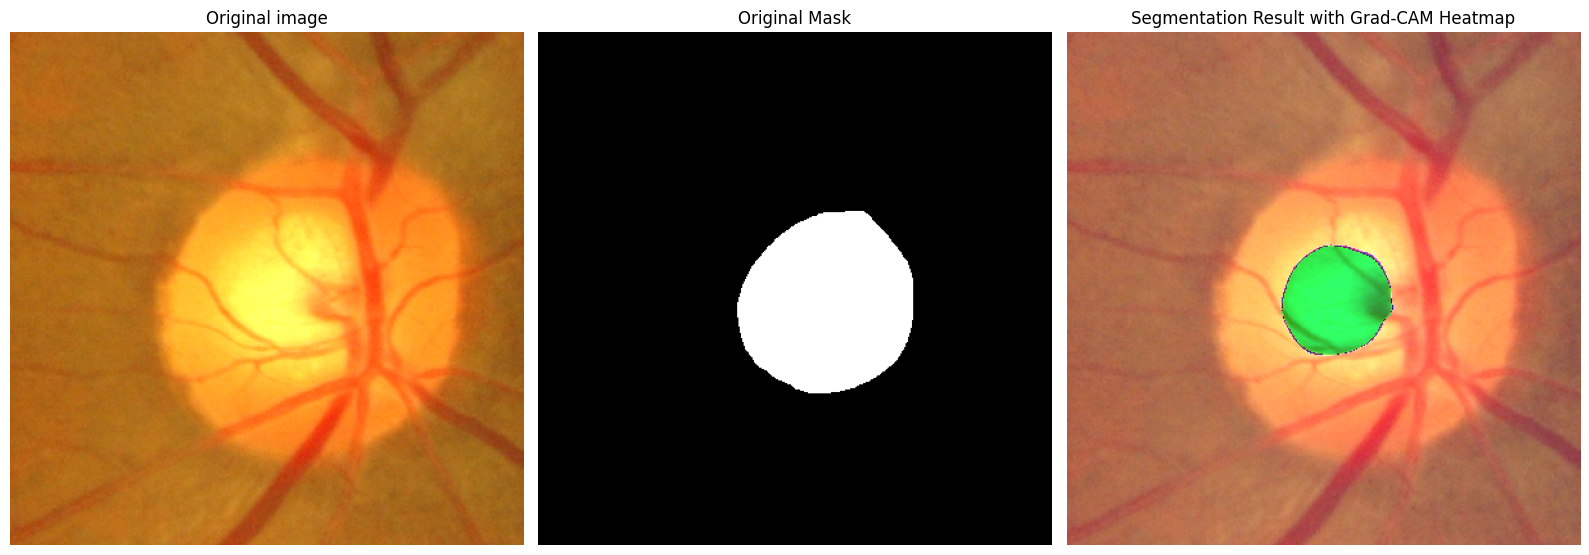

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def apply_heatmap_overlay(heatmap, image_path, alpha=0.4, colormap='jet'):
    """
    Apply a heatmap overlay on the original image.

    Parameters:
        heatmap (numpy.array): The Grad-CAM heatmap.
        image_path (str): Path to the original image.
        alpha (float): Transparency level of the overlay.
        colormap (str): Colormap to use for the heatmap.

    Returns:
        numpy.array: Image with the heatmap overlay.
    """
    image = cv.imread(image_path, cv.IMREAD_COLOR)
    # image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Normalize the heatmap to the range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply the colormap to the heatmap
    colormap = plt.cm.get_cmap(colormap)
    colored_heatmap = colormap(heatmap)

    # Convert the colormap to RGB
    colored_heatmap = np.uint8(colored_heatmap[:, :, :3] * 255)

    # Overlay the heatmap on the original image
    overlay_image = colored_heatmap * alpha + image
    overlay_image = np.uint8(overlay_image)

    return overlay_image

# Apply the heatmap overlay on the original image
overlay_image = apply_heatmap_overlay(heatmap, img_path)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 10))
display_image_on_axis(axes[0], cv.imread(train[image_path], cv.IMREAD_COLOR), f"Original image")
display_image(axes[1], train_mask_cup[image_path], f"Original Mask")
axes[2].imshow(overlay_image)
axes[2].axis('off')
axes[2].set_title("Segmentation Result with Grad-CAM Heatmap")
plt.tight_layout()
plt.show()